# Quality control, processing and normalisation of in vivo SI data

In [1]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read in data
adata = scv.read("../../data/SI.loom", sparse=True, cache=True)
scv.settings.set_figure_params('scvelo')
scv.utils.show_proportions(adata)
scv.utils.cleanup(adata, clean='all')
adata.X = adata.X.astype('float64') 
adata.X = adata.X.toarray()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.66 0.28 0.06]


In [3]:
#add ensembl IDs (extracted from loomfile in R)
gene_mapping = pd.read_csv("../../data/gene_mapping.csv")
adata.var['accession'] = list(gene_mapping['accession'])

#make gene names unique
adata.var_names_make_unique()

In [4]:
#add information on batch and whether cell is individual/in clump etc
adata.obs['batch']= [i.split('.')[0] for i in adata.obs.index]    
adata.obs['time_point']= [i.split('_')[0] for i in adata.obs.index]
adata.obs['cell_num']= [i.split('_')[-1] for i in adata.obs.index]

In [5]:
adata_adult = adata[adata.obs.time_point == 'AMG']
set(adata_adult.obs['cell_num'])

{'0', '1', '1+D', '1?', '1B', '1Irr', '1L', '1S', '2', '3', 'C', 'D'}

In [6]:
#only retain individual cells
print(set(adata.obs['cell_num']))
accepted = set(["1","1s","1D","1Irr","1B","1S","1+D","1L","1?","NA"])
adata = adata[adata.obs['cell_num'].isin(accepted),:]

{'1Irr', '1S', '1+D', '0', 'NA', '1L', 'c', '2D', '1D', '1B', 'D', '4', '1or2', '2', '1s', '2s', '1+C', '1', '2+D', '3', '1 or 2', '1?', 'C'}


In [7]:
#remove cells from batch 13 (test plates)
adata = adata[adata.obs['batch']!= "P00_13",:]

In [8]:
#add batch information for each time point and change AMG timepoint
#to p60
adata.obs.time_point = list(adata.obs.time_point)
adata.obs.time_point[adata.obs.time_point == "AMG"] = "P60"
adata.obs["batch_E12"] = "None"
adata.obs["batch_E12"][adata.obs["time_point"] == "E12"] = adata.obs["batch"][adata.obs["time_point"] == "E12"]
adata.obs["batch_E16"] = "None"
adata.obs["batch_E16"][adata.obs["time_point"] == "E16"] = adata.obs["batch"][adata.obs["time_point"] == "E16"]
adata.obs["batch_P00"] = "None"
adata.obs["batch_P00"][adata.obs["time_point"] == "P00"] = adata.obs["batch"][adata.obs["time_point"] == "P00"]
adata.obs["batch_P60"] = "None"
adata.obs["batch_P60"][adata.obs["time_point"] == "P60"] = adata.obs["batch"][adata.obs["time_point"] == "P60"]

Trying to set attribute `.obs` of view, making a copy.


In [9]:
#add information on counts, number of genes and fraction mitochondrial
#genes for quality control

adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_genes_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = np.sum(adata[:,mt_genes_mask].X, axis=1) / np.sum(adata.X, axis=1)

... storing 'batch' as categorical
... storing 'time_point' as categorical
... storing 'cell_num' as categorical
... storing 'batch_E12' as categorical
... storing 'batch_E16' as categorical
... storing 'batch_P00' as categorical
... storing 'batch_P60' as categorical


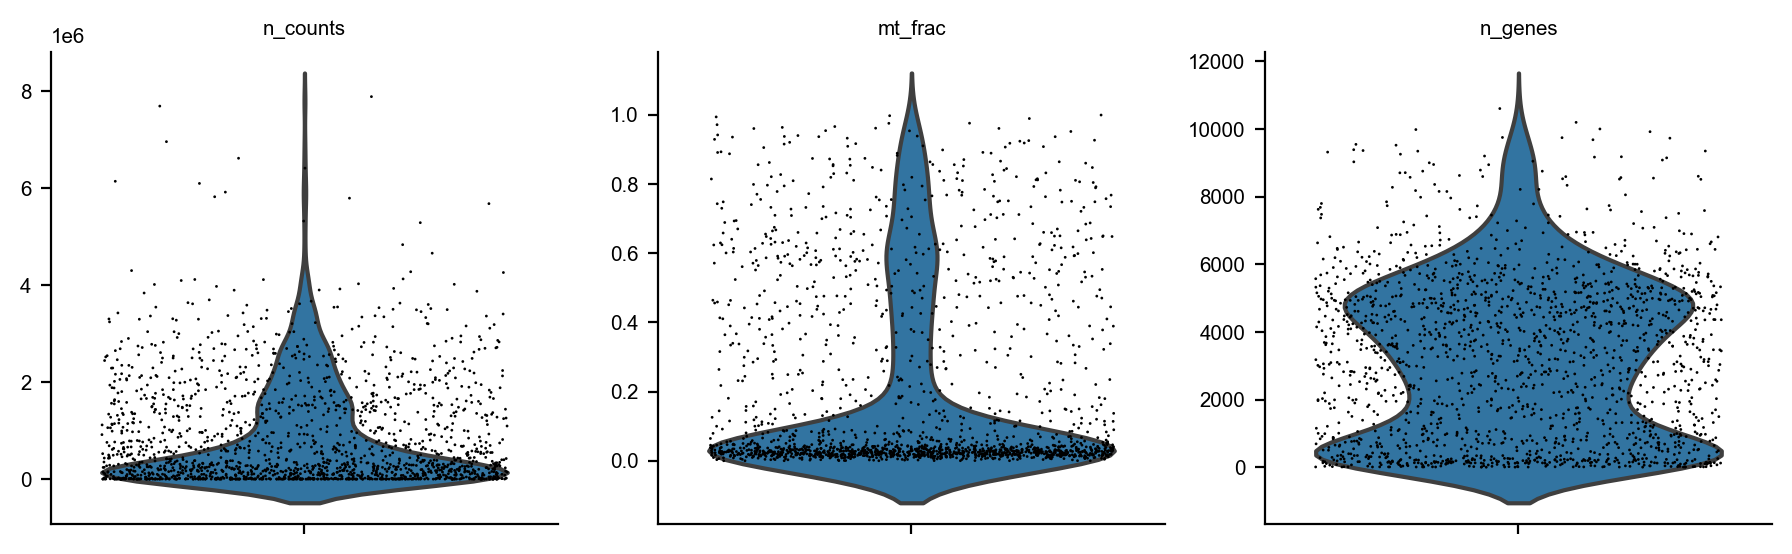

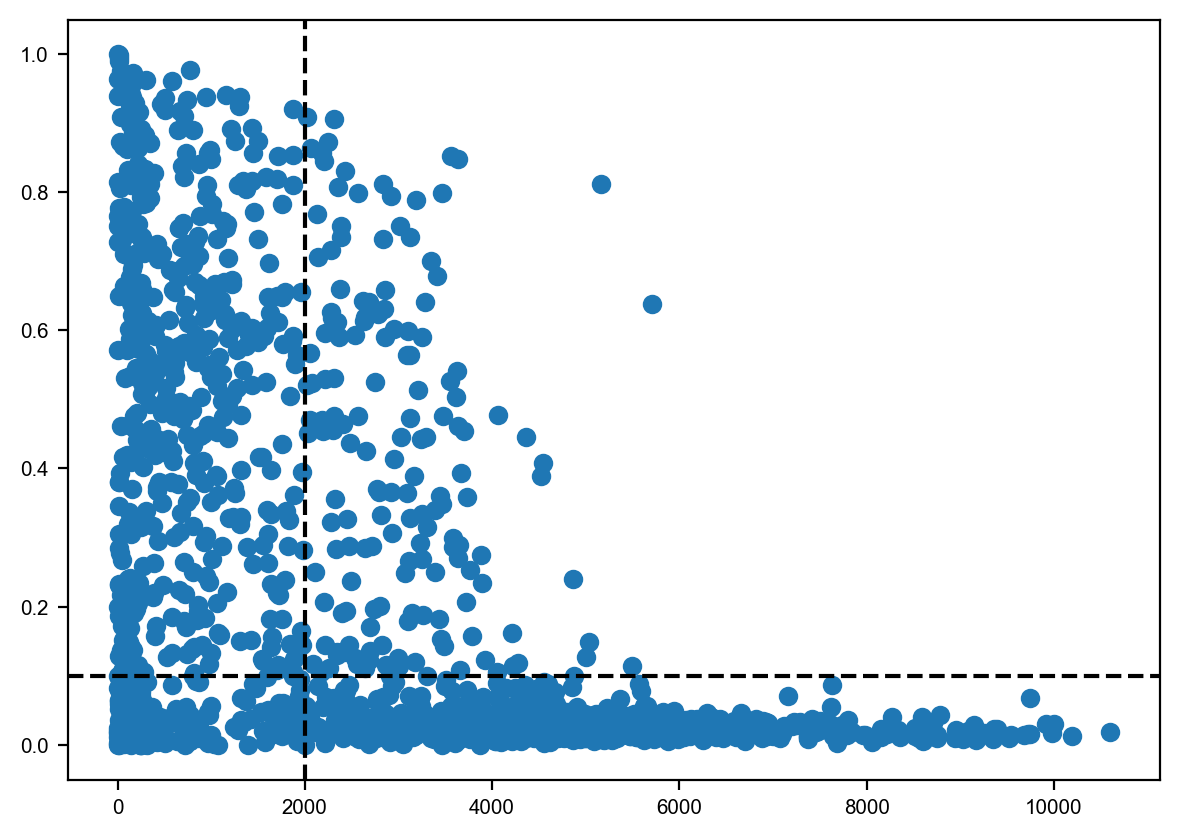

In [10]:
#visualise quality control metrics

sc.pl.violin(adata, ['n_counts', 'mt_frac','n_genes'],
             jitter=0.4, multi_panel=True)
fig, ax = plt.subplots()
plt.scatter(adata.obs['n_genes'],adata.obs['mt_frac'])
ax.axhline(0.1,color='black',ls='--')
ax.axvline(2000,color='black',ls='--')

In [11]:
#filter cells with more than 10% mitochondrial reads or
#expressing less than 2000 genes

adata = adata[adata.obs['mt_frac'] < 0.1]
adata = adata[adata.obs['n_genes'] > 2000]

In [22]:
adata[:,"Mesp1"].X[adata[:,"Mesp1"].X > 0]
adata[:,"Met"].X[adata[:,"Met"].X > 0]
adata[:,"Cdh3"].X[adata[:,"Cdh3"].X > 0]
adata[:,"Il18"].X[adata[:,"Il18"].X > 0]

ArrayView([1.680e+02, 1.000e+00, 1.450e+02, 1.630e+02, 1.000e+00,
           1.370e+02, 4.000e+01, 1.230e+02, 7.480e+02, 1.000e+00,
           1.000e+00, 1.300e+01, 1.400e+02, 1.000e+00, 1.840e+02,
           1.751e+03, 2.000e+00, 1.000e+00, 2.100e+01, 4.460e+02,
           1.000e+00, 1.990e+02, 5.700e+01, 2.890e+02, 2.100e+02,
           1.000e+00, 1.190e+02, 1.530e+02, 4.100e+01, 1.600e+01,
           8.300e+01, 9.600e+01, 3.900e+01], dtype=float32)

In [13]:
adata[:,"Sox2"].X

ArrayView([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.

In [15]:
adata.obs["Meis2"] = adata[:,"Meis2"].X
adata.obs["time_point"][adata.obs['Meis2']>10]

index
E12_01.B0006_1D      E12
E12_01.D0004_1       E12
E12_01.D0005_1       E12
E12_01.E0001_1       E12
E12_01.E0006_1       E12
E12_01.G0004_1Irr    E12
E12_02.A0012_1       E12
E12_02.B0003_1       E12
E12_02.B0005_1       E12
E12_02.B0006_1       E12
E12_02.C0010_1       E12
E12_02.F0008_1       E12
E12_03.C0001_1       E12
E12_03.G0012_1       E12
E12_04.A0001_1       E12
E16_01.A0227_1B      E16
E16_01.A0124_1       E16
E16_01.A0244_1       E16
E16_02.A0172_1       E16
E16_02.A0181_1       E16
E16_02.A0188_1       E16
E16_02.A0189_1       E16
P00_09.A0100_NA      P00
P00_09.A0148_NA      P00
P00_09.A0166_NA      P00
P00_09.A0183_NA      P00
P00_11.A0320_NA      P00
P00_11.A0328_NA      P00
P00_11.A0347_NA      P00
P00_11.A0351_NA      P00
P25_01.A1578_1       P25
P25_01.A1600_1Irr    P25
AMG_03.A0012_1       P60
AMG_01.A0244_1B      P60
AMG_02.A0349_1       P60
P00_16.A0819_NA      P00
P00_16.A0843_NA      P00
P00_17.A0917_NA      P00
P00_17.A0927_NA      P00
Name: time_point, d

In [11]:
#remove contaminating macrophages (Cd14 expressing), 
#epithelial cells (Cdh1 expressing) and mesenchymal cells (Meis2 expressing)

adata.obs["Cd14"] = adata[:,"Cd14"].X
adata.obs["Cdh1"] = adata[:,"Cdh1"].X
adata.obs["Meis2"] = adata[:,"Meis2"].X

print(adata[adata.obs['Cd14']>9,:]) #6 cells
print(adata[adata.obs['Cdh1']>9,:]) #9 cells
print(adata[adata.obs['Meis2']>9,:]) #39 cells


adata = adata[adata.obs['Cd14']<10,:]
adata = adata[adata.obs['Cdh1']<10,:]
adata = adata[adata.obs['Meis2']<10,:]

Trying to set attribute `.obs` of view, making a copy.


View of AnnData object with n_obs × n_vars = 6 × 55536 
    obs: 'batch', 'time_point', 'cell_num', 'batch_E12', 'batch_E16', 'batch_P00', 'batch_P60', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'Cd14', 'Cdh1', 'Meis2'
    var: 'accession'
    layers: 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 9 × 55536 
    obs: 'batch', 'time_point', 'cell_num', 'batch_E12', 'batch_E16', 'batch_P00', 'batch_P60', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'Cd14', 'Cdh1', 'Meis2'
    var: 'accession'
    layers: 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 39 × 55536 
    obs: 'batch', 'time_point', 'cell_num', 'batch_E12', 'batch_E16', 'batch_P00', 'batch_P60', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'Cd14', 'Cdh1', 'Meis2'
    var: 'accession'
    layers: 'spliced', 'unspliced'


In [12]:
#check how many cells retained at each time point.

print(adata[adata.obs.time_point == "E12"])
print(adata[adata.obs.time_point == "E14"])
print(adata[adata.obs.time_point == "E16"])
print(adata[adata.obs.time_point == "P00"])
print(adata[adata.obs.time_point == "P25"])
print(adata[adata.obs.time_point == "AMG"])

View of AnnData object with n_obs × n_vars = 143 × 55536 
    obs: 'batch', 'time_point', 'cell_num', 'batch_E12', 'batch_E16', 'batch_P00', 'batch_P60', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'Cd14', 'Cdh1', 'Meis2'
    var: 'accession'
    layers: 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 20 × 55536 
    obs: 'batch', 'time_point', 'cell_num', 'batch_E12', 'batch_E16', 'batch_P00', 'batch_P60', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'Cd14', 'Cdh1', 'Meis2'
    var: 'accession'
    layers: 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 129 × 55536 
    obs: 'batch', 'time_point', 'cell_num', 'batch_E12', 'batch_E16', 'batch_P00', 'batch_P60', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'Cd14', 'Cdh1', 'Meis2'
    var: 'accession'
    layers: 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 432 × 55536 
    obs: 'batch', 'time_point', 'cell_num', 'batch_E12', 'batch_E16', 'batch_P00', 'batch_P60', '

In [13]:
#filter genes - must be present in at least 3 cells and at least 10 counts  

print('Total number of genes: {:d}'.format(adata.n_vars))

sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=10)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 55536


Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 23299


In [14]:
#add raw count information to adata

adata.layers["counts"] = adata.X.copy()

In [15]:
#normalize and take log counts

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)

In [16]:
#save adata with no filtering as adata.raw

adata.raw = adata

... storing 'phase' as categorical


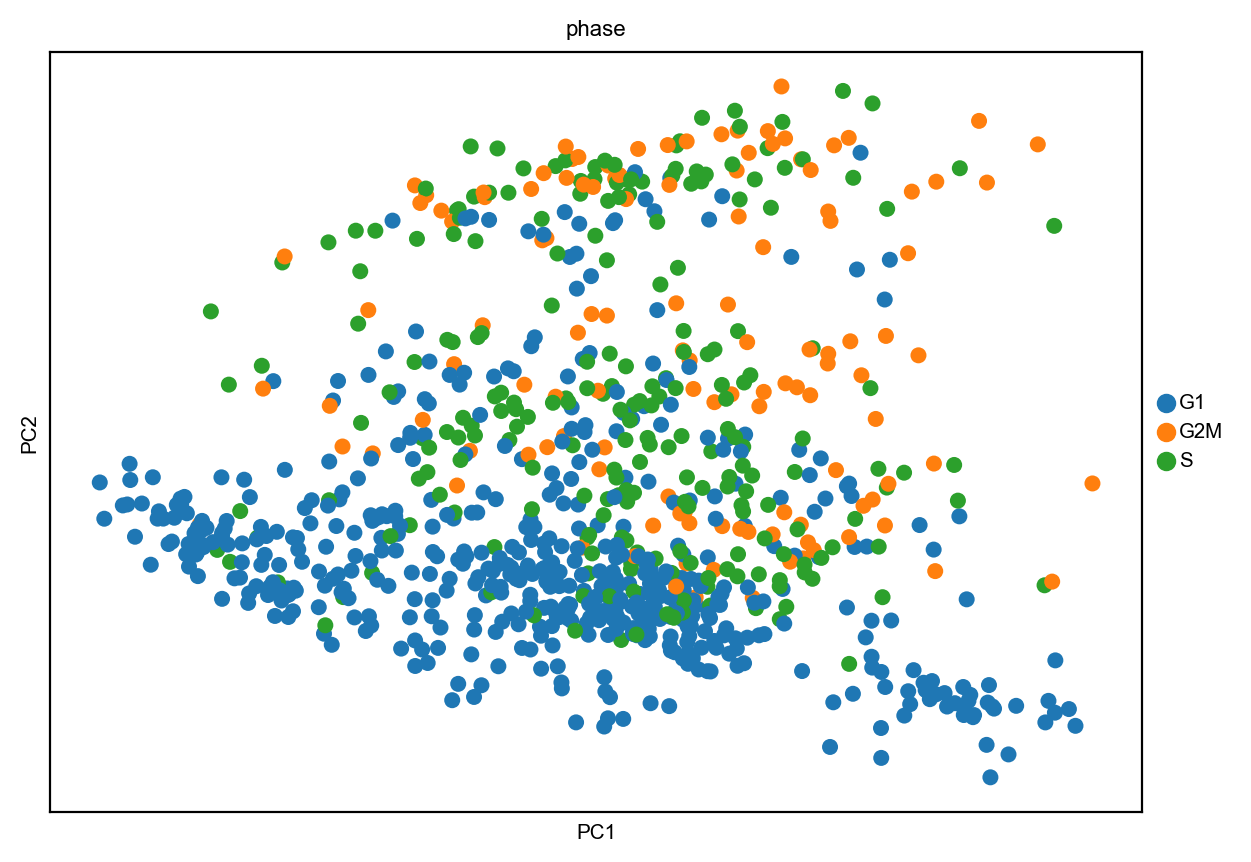

In [17]:
#score cell cycle

def score_cell_cycle(adata):
    cell_cycle_genes = [x.strip() for x in open('../../data/regev_lab_cell_cycle_genes.txt')]
    #mouse cell cycle genes have to be in camel case
    cell_cycle_genes = [x[0] + x[1:].lower() for x in cell_cycle_genes]
    cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_scatter(adata, color='phase')
    adata.obs["cc_dif"] =  adata.obs["S_score"] - adata.obs["G2M_score"]
    return adata

adata = score_cell_cycle(adata)

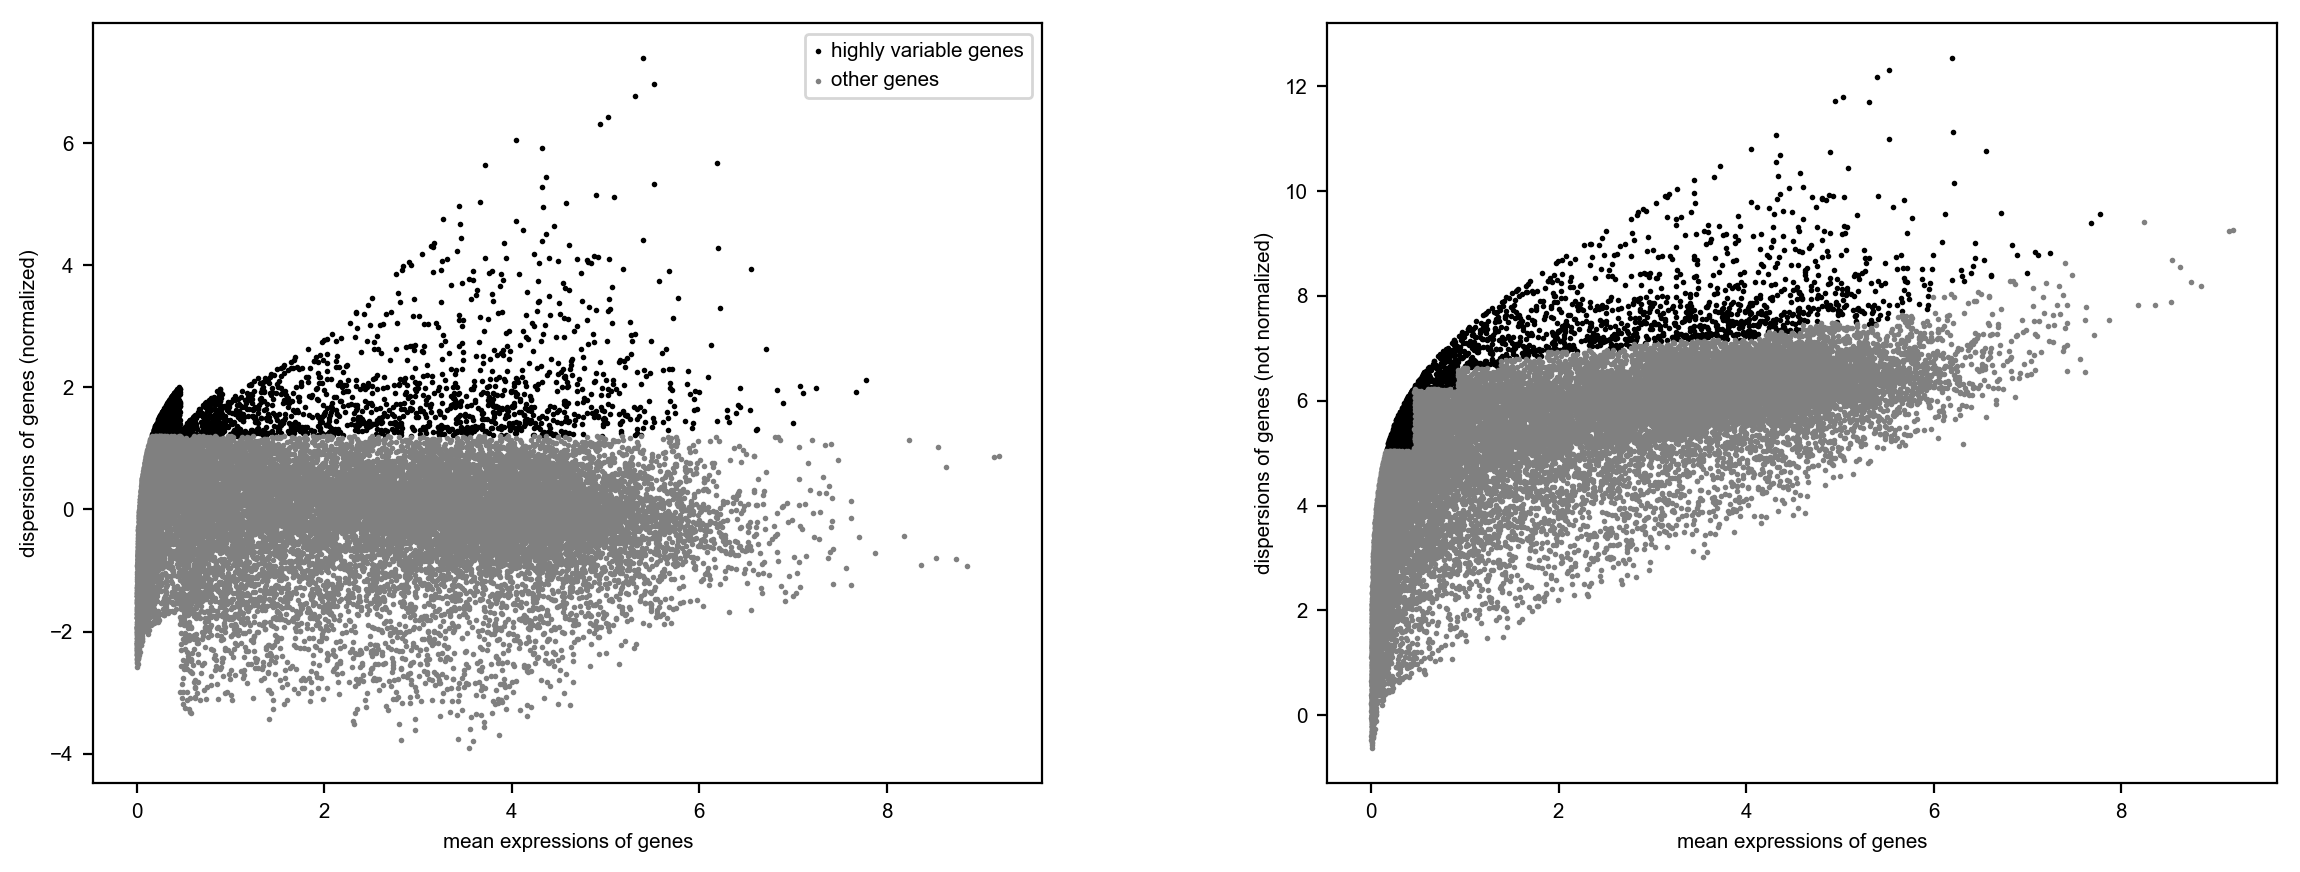

In [18]:
#calculate highly variable genes

sc.pp.highly_variable_genes(adata,n_top_genes =2000)
sc.pl.highly_variable_genes(adata)

In [19]:
#save data

data_mat = adata.X.T

dat = pd.DataFrame(data_mat)
dat.index = adata.var_names
dat.columns = adata.obs_names

dat.to_csv("../../output/adata.csv")
adata.obs.to_csv("../../output/obs.csv")
adata.var.to_csv("../../output/var.csv")

adata.write("../../output/adata.h5ad")